In [1]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from keras.models import model_from_json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# get_ipython().run_line_magic('matplotlib', 'inline')

import cv2
import time
import pickle
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras

from os import listdir

from keras import models
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from keras.layers import Conv2D, ZeroPadding2D, Activation, concatenate, Dropout
from keras.models import Model
# from keras.layers import

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.backend import set_session
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model


In [2]:
genuine_images_path = ("D:/imsave/genuine")
forged_images_path = ("D:/imsave/forged")
orig_groups, forg_groups = [], []


In [3]:
genuine_image_filenames = listdir(genuine_images_path)
#print(genuine_image_filenames)
forged_image_filenames = listdir(forged_images_path)
orig_groups.append(genuine_image_filenames)
print("orig_groups",orig_groups)
forg_groups.append(forged_image_filenames)
print("forg_groups",forg_groups)
len(orig_groups),len(forg_groups)



orig_groups [['WhatsApp Image 2022-06-28 at 12.32.49 PM.jpeg']]
forg_groups [['WhatsApp Image 2022-06-28 at 3.14.11 PM (1).jpeg']]


(1, 1)

In [4]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print("orig_lengths",orig_lengths)
print("forg_lengths",forg_lengths)

orig_lengths [1]
forg_lengths [1]


In [5]:
orig_lengths,forg_lengths

([1], [1])

In [6]:
orig_test = orig_lengths 
forg_test = forg_lengths


In [7]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [8]:
forge = []
org=[]

In [9]:
for file in os.listdir(genuine_images_path):
    #print(file)
     org.append(genuine_images_path+'/'+file)
print(org[0])

D:/imsave/genuine/WhatsApp Image 2022-06-28 at 12.32.49 PM.jpeg


In [10]:
for file in os.listdir(forged_images_path):
    forge.append(forged_images_path+'/'+file)
print(forge[0])


D:/imsave/forged/WhatsApp Image 2022-06-28 at 3.14.11 PM (1).jpeg


In [11]:
org_test=org[0]
forge_test=forge[0]
print("org_test=",org_test)
print("forge_test=",forge_test)


org_test= D:/imsave/genuine/WhatsApp Image 2022-06-28 at 12.32.49 PM.jpeg
forge_test= D:/imsave/forged/WhatsApp Image 2022-06-28 at 3.14.11 PM (1).jpeg


In [12]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    
     # #     print("k==",k)
     # k = np.random.randint(len(orig_test))
    orig_img_names = [org[0]]
    forg_img_name = [forge[0]]
    print("orig_img_names=",orig_img_names)
    print("forg_img_name=",forg_img_name)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[0], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))
    ax1.imshow(orig_img1, cmap='gray')
    ax2.imshow(orig_img2, cmap='gray')
    ax3.imshow(forg_img, cmap='gray')
    ax1.set_title('Genuine Copy')
    ax1.axis('off')

    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')
#     fig.savefig("D:/imsave")
    #return ax1, ax2, ax3


orig_img_names= ['D:/imsave/genuine/WhatsApp Image 2022-06-28 at 12.32.49 PM.jpeg']
forg_img_name= ['D:/imsave/forged/WhatsApp Image 2022-06-28 at 3.14.11 PM (1).jpeg']


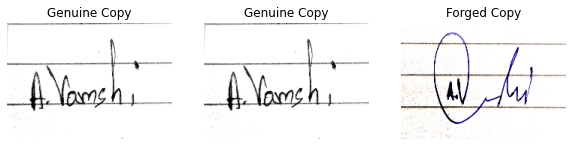

In [13]:
visualize_sample_signature()

In [14]:
#visualize_sample_signature()

In [15]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        orig_pairs.extend(org)
        #print("orig_pairs==",orig_pairs)
        forg_pairs.extend(forge)
        #print("forg_pairs==",forg_pairs)

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        #print("all pairs==",len(all_pairs))
        all_labels = gen_gen_labels + gen_for_labels
        #print("all_labels==", all_labels)
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        # for  pair in (all_pairs):
        #print("pairs",pairs)
        targets=np.zeros((batch_size,))
        img1 = cv2.imread(org_test, 0)
        img2 = cv2.imread(forge_test, 0)
        img1 = cv2.resize(img1, (img_w, img_h))
        img2 = cv2.resize(img2, (img_w, img_h))
        img1 = np.array(img1, dtype = np.float64)
        img2 = np.array(img2, dtype = np.float64)
        img1 /= 255
        img2 /= 255
        img1 = img1[..., np.newaxis]
        img2 = img2[..., np.newaxis]
        pairs[0][k, :, :, :] = img1
        pairs[1][k, :, :, :] = img2
        targets = all_labels
        k += 1
        if k == batch_size:
                    yield pairs, targets
                    k = 0
                    pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                    targets=np.zeros((batch_size,))



In [16]:
generate_batch(orig_test, forge_test, 1)

<generator object generate_batch at 0x0000017A8EDBDF20>

In [17]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [18]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [19]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [20]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape=input_shape))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2)))

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1,
                   kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1,
                   kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1,
                   kernel_initializer='glorot_uniform'))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=None, activation='relu'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, kernel_regularizer=None, activation='relu'))  # softmax changed to relu

    return seq

In [21]:
input_shape=(img_h, img_w, 1)

In [22]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance, name = 'head_model')
# Specify available GPUs
#p_model = multi_gpu_model(model, gpus=4)

In [23]:
batch_sz = 32
num_train_samples = 10*10 + 10*8
num_val_samples = num_test_samples = 10*10 + 10*8
num_train_samples, num_val_samples, num_test_samples

(180, 180, 180)

In [24]:
model.load_weights('FashionMNIST_weights.h5')

In [25]:
model.compile(loss=contrastive_loss,
         optimizer='rmsprop',
         metrics=['accuracy'])

In [26]:
model.summary()

Model: "head_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]        

In [27]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    print("dmax=",dmax)
    dmin = np.min(predictions)
    print("dmin=",dmin)
    nsame = np.sum(labels == 1) #similar
    print("nsame=",nsame)
    ndiff = np.sum(labels == 0) #different
    print("ndiff=",ndiff)
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
        print("tp",tp)
        print("tn",tn)
        print("fp",fp)
        print("fn",fn)
#         tpr = float(np.sum(labels[idx1] == 1)) / nsame
        print("tpr",tpr)
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        print("tnr",tnr)
        
        
        acc = 0.5 * (tpr + tnr)
        print("acc",acc)
        pr = tp / (tp + fp)
        print("pr=",pr)
        re = tp / (tp + fn)
        print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        print("far=",far)
        frr = fn / (fn + tp)
        print("frr=",frr)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh

In [28]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
#     if plot_far_frr:
#         fig = plt.figure(figsize = (10,10))
#         ax = fig.add_subplot(121)
#         ax.plot(ds, far_plot, color = 'red')
#         ax.plot(ds, frr_plot, color = 'blue')
#         ax.set_title('Error rate')
#         ax.legend(['FAR', 'FRR'])
#         ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
#         ax1 = fig.add_subplot(122)
#         ax1.plot(ds, pr_plot, color = 'green')
#         ax1.plot(ds, re_plot, color = 'magenta')
#         ax1.set_title('P-R curve')
#         ax1.legend(['Precision', 'Recall'])
#         ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        #plt.show()
    return max_acc, best_thresh

In [29]:
def load_and_check_model(weight):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    model.load_weights(weight)

    val_gen = generate_batch(orig_groups, forg_groups, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        #print("tr_y",tr_y)
        pred.append(model.predict([img1, img2])[0][0])
        #print("pred=",pred)

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold

In [30]:
acc_thresh = []
for i in range(1,27,1):
    acc_thresh.append(load_and_check_model('D:/model2/signet-bhsig260-full-xavier-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  50.0 %
For model 2 Validation Accuracy =  50.0 %
For model 3 Validation Accuracy =  50.0 %
For model 4 Validation Accuracy =  50.0 %
For model 5 Validation Accuracy =  50.0 %
For model 6 Validation Accuracy =  50.0 %
For model 7 Validation Accuracy =  50.0 %
For model 8 Validation Accuracy =  50.0 %
For model 9 Validation Accuracy =  50.0 %
For model 10 Validation Accuracy =  50.0 %
For model 11 Validation Accuracy =  50.0 %
For model 12 Validation Accuracy =  50.0 %
For model 13 Validation Accuracy =  50.0 %
For model 14 Validation Accuracy =  50.0 %
For model 15 Validation Accuracy =  50.0 %
For model 16 Validation Accuracy =  50.0 %
For model 17 Validation Accuracy =  50.0 %
For model 18 Validation Accuracy =  50.0 %
For model 19 Validation Accuracy =  50.0 %
For model 20 Validation Accuracy =  50.0 %
For model 21 Validation Accuracy =  50.0 %
For model 22 Validation Accuracy =  50.0 %
For model 23 Validation Accuracy =  50.0 %
For model 24 Validat

In [31]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    #for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

In [32]:
#acc, threshold = test_model('FashionMNIST_weights.h5')
acc,threshold = test_model("D:/model2/signet-bhsig260-full-xavier-008.h5")
acc, threshold

(0.5, 0.0017756499582901597)

In [33]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
#     print("test_gen=",test_gen)
    test_point, test_label = next(test_gen)
#     print("test_point=",test_point)
#     print("test_label=",test_label)
    img1, img2 = test_point[0], test_point[1]
#     print("img1, img2=",img1, img2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff >=threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

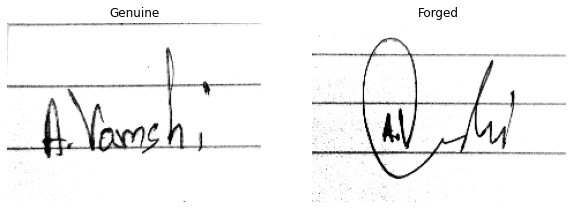

Difference Score =  0.00177565
Its a Forged Signature


In [34]:
predict_score()